# JPEG Analysis
## An in-depth look at the JPEG File Interchange Format with Python3
#### Skyler Rankin 2019
##### *Version 0.1*

### Introduction
This notebook attempts to explore the mechanisms at play behind one of the most widely used image file formats. In short, by parsing the file byte by byte, and using specification reference, we can interpret all of the information stored in the file, and even generate the corresponding image without a pre-built image viewer. The primary reference used will be the report given by Ecma-Internation found [here](https://www.ecma-international.org/publications/files/ECMA-TR/ECMA%20TR-098.pdf).

#### Table of Contents
[link](#one)

### <a name="one"></a>This is the Heading

### Section 2: Importing an Image
First, we must select an image to work with. I have included a small default image with this repository for testing, but feel free to add your own by adding the file to the project root and changing the filename in the code below.

In [1]:
from IPython.display import Image
image_filename = "colors.jpg"
Image(image_filename, width=100)

### Section 3: Basic Structure
The structure of a JPEG file relies upon a system of **markers**. These are specific 2-byte sequences that are reserved for a specific purpose, so that when you see one in the file, you can be sure of its purpose. For convenience, I will represent these byte sequences as hex values preceeded by `0x`, meaning the decimal number `78` is represented as `01001110` as binary in the image file, but is written as `0x4E` for our purposes. In the JPEG File Format, all markers are preceeded by `0xFF`, which makes the marker two btes in total.
The first markers to look for are the **SOI** and **EOI** markers. These signify **start of image** and **end of image** respectively.

Marker | Value
--- | --- 
SOI | 0xD8
EOI | 0xD9

We can be sure that no important information for the image will come before the `SOI` marker, and no information will come after the `EOI`. The information between these markers can be referred to as a segment. Other markers use a different system to define their segment. A common idea is using a **header**. This is a small sequence of bytes at the beginning of the segment that describe what that segment contains. The specifics for the headers are dependent on the marker type, but we will see many of these headers as we parse the image file. An example of this is the `SOF0` marker, which denotes the **start of frame 0**. This segment uses the marker `0xC0` and contains information regarding the image data.


In [2]:
def hti(h):
    return int.from_bytes(h, byteorder='big')

print(hti(b'\xD8'))
print(16*13+8)

216
216


### Section 4: Parsing Segments

all the segments welaas  parse

firs tis siof

In [3]:
def parse_SOF0(file):
    #length = 8 + (#components * 3)
    length = hti(file.read(2))
    #bits/sample
    precision = hti(file.read(1))
    height = hti(file.read(2))
    width = hti(file.read(2))
    #1 = grey scale, 3 = YCbCr, 4 = CMYK
    num_components = hti(file.read(1))
    components = []
    for i in range(int((length - 8) / 3)):
        #1 = Y, 2 = Cb, 3 = Cr, 4 = I, 5 = Q
        component_id = hti(file.read(1))
        sampling_factor = hti(file.read(1))
        q_table = hti(file.read(1))
        components.append({
            "id": component_id,
            "sampling_factor": sampling_factor,
            "q_table": q_table
        })
    return {
        "length": length,
        "precision": precision,
        "height": height,
        "width": width,
        "num_components": num_components,
        "components": components
    }

next is fht

thsld dqt

In [4]:
import numpy as np

def parse_DQT(file):
    #length = 6+2(number of components)
    length = hti(file.read(2))
    tables = []
    pos = length-2
    
    while pos > 0:
        qt = hti(file.read(1))
        number = qt&0xF
        precision = qt >> 4
        table = {
            "id": number,
            "precision": precision
        }
        data = []
        for i in range(64*(precision+1)):
            data.append(hti(file.read(1)))
        matrix = np.array(data)
        matrix = matrix.reshape(8,8)
        
        table["matrix"] = matrix
        tables.append(table)
        
        pos-=(1 + (64*(1+precision)))
        
    return {
        "length": length,
        "tables": tables
    }

help
help

huffyman shit

In [5]:
def generate_bitstrings(table):
    bitstrings = {}    
    value = 0
    for i in range(1,table["last non-zero"]+2):
        if table["lengths"][i-1] == 0:
            continue
        strings = []
        for code in range(table["lengths"][i-1]):
            strings.append(value)
            value+=1
        bitstrings[i] = strings
        value <<= 1
    return bitstrings

In [6]:
class TreeNode:
    def __init__(self, value=None, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right
    
    def get_node(self, path):
        if path == '':
            return self
        return self.left.get_node(path[1:]) if path[0:1] == '0' else self.right.get_node(path[1:])
    
def make_node(root, path, value):
    if path=="":
        root.value = value
    elif path[:1] == "0":
        if root.left == None:
            root.left = TreeNode()
        make_node(root.left, path[1:], value)
    else:
        if root.right == None:
            root.right = TreeNode()
        make_node(root.right, path[1:], value)
        
def generate_tree(table):
    bitstrings = generate_bitstrings(table)
    root = TreeNode(value=None)
    value_index = 0
    for level in range(1, table["last non-zero"]+2):
        if level not in bitstrings.keys():
            continue
        for s in bitstrings[level]:
            binary = str(bin(s))[2:]
            path = ("0"*(level-len(binary)))+binary
            make_node(root, path, table["symbols"][value_index])
            value_index+=1
    return root

#import graphviz
#graph = graphviz.Digraph()
#graph.edge("a", "b")
#graph.edge("a", "c")
#graph.edge("b", "d")
#graph.edge("b", "e")
#graph.edge("c", "t")
#graph

In [7]:
def test_huffman_tree(table, tree):
    bitstrings = generate_bitstrings(table)
    print("---Testing Huffman Tree Implementation")
    print("bitstrings: {}".format(bitstrings))
    code = 0
    for level in bitstrings:
        print("Level = {}".format(level))
        for string in bitstrings[level]:
            binary = str(bin(string))[2:]
            path = ("0"*(level-len(binary)))+binary
            symbol = tree.get_node(path).value
            print("\t{}: Expected {}, Found {}".format(path, table["symbols"][code], symbol))
            code+=1
    

format is Y Cb Cr for each MCU, in order. 

In [8]:
bit_buffer = ""
def read_bit(file):
    global bit_buffer
    if bit_buffer == "":
        byte = file.read(1)
        bit_buffer = str(bin(hti(byte)))[2:]
        if len(bit_buffer) < 8:
            bit_buffer = "0"*(8 - len(bit_buffer)) + bit_buffer
        #print("\tbit_buffer update: {}".format(bit_buffer))
    bit = int(bit_buffer[:1])
    bit_buffer = bit_buffer[1:]
    return bit

In [9]:
def parse_DHT(file):
    length = hti(file.read(2))
    pos = length
    count = 0
    tables = []

    while pos > 0 and count < 4:
        count+=1
        ht_info = hti(file.read(1))
        pos-=1

        number = ht_info&0xF
        ht_type = ht_info >> 4
        
        table = {"id": number, "type": ht_type}
        
        lengths = []
        last = None
        for i in range(16):
            l = hti(file.read(1))
            lengths.append(l)
            if l != 0:
                last = i
        table["lengths"] = lengths
        table["last non-zero"] = last
        pos-=16
                
        symbols = []
        for i in range(16):
            if lengths[i] > 0:
                for j in range(lengths[i]):
                    symbols.append(hti(file.read(1)))
                    pos-=1
        table["symbols"] = symbols        
        tables.append(table)
        
    trees = {}
    for table in tables:
        if table["id"] not in trees.keys():
            trees[table["id"]] = {}
            
        if table["type"] == 0:
            trees[table["id"]]["DC"] = generate_tree(table)
            #test_huffman_tree(table, trees[table["id"]]["DC"])
        elif table["type"] == 1:
            trees[table["id"]]["AC"] = generate_tree(table)
        
    return {
        "length": length,
        "trees": trees
    }

In [10]:
def parse_SOS(file):
    #length = 6+2*(number of components)
    length = hti(file.read(2))
    number_components = hti(file.read(1))
    components = []
    for i in range(number_components):
        cid = hti(file.read(1))
        table = hti(file.read(1))
        components.append({
            "id": cid,
            "AC": table&0xF,
            "DC": table>>4
        })
    file.read(3)
    
    return {
        "length": length,
        "number of components": number_components,
        "components": components
    }    

In [11]:
def read_image_data(file):
    mcus = []
    mcu = []
    for i in range(data["SOS"][0]["number of components"]):
        trees = data["DHT"][0]["trees"]
        component = data["SOS"][0]["components"][i]
        #print("Reading Component {}: {}".format(i, component))
        
        #DC value
        tree = trees[component["DC"]]["DC"]
        while tree.value == None:
            bit = read_bit(file)
            tree = tree.get_node(str(bit))
        dct = [tree.value]
        #print("DC Value = {}".format(tree.value))
        
        #63 AC values
        tree = trees[component["AC"]]["AC"]
        for i in range(63):
            while tree.value == None:
                bit = read_bit(file)
                tree = tree.get_node(str(bit))
            dct.append(tree.value)
            if tree.value == 0:
                break;
            tree = trees[component["AC"]]["AC"]
        
        if len(dct) < 64:
            dct = dct + (64-len(dct))*[0]
        dct = np.array(dct)
        dct = dct.reshape(8,8)
        mcu.append(dct)
    mcus.append(mcu)
    print(mcus)

In [12]:
def next_segment(file):
    markers = {
        0xFFD8: "SOI",
        0xFFE0: "APP0",
        0xFFC0: "SOF0",
        0xFFC4: "DHT",
        0xFFDB: "DQT",
        0xFFDA: "SOS",
        0xFFD9: "EOI",
    }
    
    b1 = file.read(1)
    b2 = file.read(1)

    while hti(b1+b2) not in markers.keys():
        b1 = b2
        b2 = file.read(1)
        
    m = hti(b1+b2)
    return markers[m]

file = open(image_filename, "rb")
data = {
    "SOF0": [],
    "DHT": [],
    "DQT": [],
    "SOS": []
}

for i in range(10):
    segment = next_segment(file)
    if segment == "SOF0":
        data[segment].append(parse_SOF0(file))
    elif segment == "DHT":
        data[segment].append(parse_DHT(file))
    elif segment == "DQT":
        data[segment].append(parse_DQT(file))
    elif segment == "SOS":
        data[segment].append(parse_SOS(file))
        read_image_data(file)
        break
file.close()

[[array([[ 5,  2, 33,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]]), array([[ 6,  1, 33,  3, 20,  1,  2, 17],
       [49,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]]), array([[ 4, 20,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])]]


cosine

In [68]:
from scipy.fftpack import idctn
q1 = data["DQT"][0]["tables"][0]["matrix"]
q2 = data["DQT"][0]["tables"][1]["matrix"]

a = np.array([[ 5,  2, 33,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

#add in difference from previous DC value

#entry-for-entry product with quantization matrix
a = np.multiply(a, q2)

#inverse DCT
inverse = idctn(a, norm="ortho")

#round all values
rounded = np.round(inverse)

#add 128 to all entries
img = rounded + 128

print(img)
#clip values outside [0, 255]

test = np.array([[-416, -33, -60, 32, 48, -40, 0, 0],
                [0, -24, -56, 19, 26, 0, 0, 0],
                [-42, 13, 80, -24, -40, 0, 0, 0],
                [-42, 17, 44, -29, 0, 0, 0, 0],
                [18, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0]])
#r = idctn(test, norm="ortho")
#r = np.round(r)

[[146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]
 [146. 137. 123. 113. 113. 122. 135. 144.]]


<module 'matplotlib.pyplot' from 'c:\\users\\skyle\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

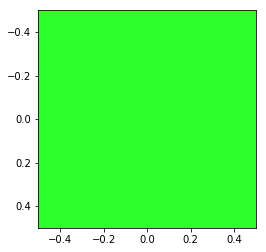

In [37]:
import matplotlib.pyplot as plt
img = [[[45,255,43]]]
plt.imshow(img)
plt